<a href="https://colab.research.google.com/github/RubenQuispe/Machine-Learning-con-Python-001/blob/master/Lab_17_Clus_Filtrado_Basado_Contenindo_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtrado Basado en Contenido
## Creado por [MSc. Rubén Quispe L.](https://www.linkedin.com/in/msc-rub%C3%A9n-quispe-l/)
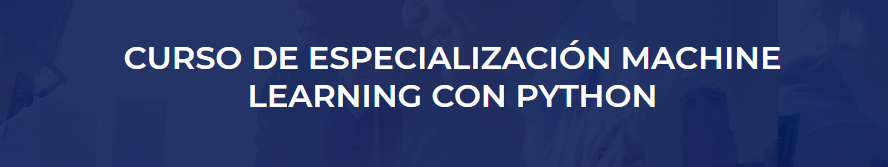

## [Curso de Especialización en Machine Learning con Python](https://eie.pe/curso-de-especializacion-en-machine-learning-con-python/)


Sistema de recomendación son una colección de algoritmos que utilizan para recomendar elementos elementos a los usuarios en función de la información obtenida del usuario. 
Estos sistemas se convertieron omnipresentes y se pueden ver comunmente en tiendas online, base de datos de películas y buscadores de empleo. 
En este nootebook, exploraremos los sistemas de recomendación basado en contenido e implementaremos una versió simple de uno usando python y la librería pandas.

# Tabla de contenido 
1. Adquesición de data
2. Pre-procesamiento
3. Filtrado Basado en Contenido 

# Adquesición de Data
Para adquerir y extraer los datos, siplemente ejecute elsiguiente scripts Bash: Dataset adqueridos de [GroupLens](https://grouplens.org/datasets/movielens/),descarguemos los datos, para ello se puede usar !Wget para descargalos desde red.



# Importando las librerías

In [22]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
ahora leemos cada archivo en sus dataframe

In [23]:
movies_df =pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


También eliminamos el año de la columna de título usando la función replace de pandas y almacenamos en una columna de año nuevo. 

# Pre-procesamiento

In [24]:
# Usando la expresión regular para encontrar un año almacenado entre parentesis
# Especificar los parámetros para no entrar en conflicto con peliculas que tienen años en sus títulos
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))', expand=False)
#Eliminando los parentesis
movies_df['year']= movies_df.year.str.extract('(\d\d\d\d)',  expand= False)
#Eliminando el año desde la columna de title
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))','')
#Aplicando la funcion de strip para deshacerse de cualquier cáracter de espacio en blanco final que pueda haber aparecido.
movies_df['title']= movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Con eso, también dividimos los valores en la columna de genero en una lista de generos para simplificar el uso futuro. Esto se puede lograr aplicando la función de string dividida de python en la columna correcta

In [25]:
# cada genero es separable por un | así simplemente tenemos que llamar a la función split en |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Dado que mantener los géneros en un formatos de lista no es óptimo para la técnica del sistema de recomendación basada en contenido, usaremos la técnica One Hot Encoding para convertir la lista de géneros en un vector donde cada columna corresponde a un valor posible de la característica. Esta codificación es necesaria para alimentar datos categóricos. En este caso, almacenamos cada género diferente en columnas que contienen 1 o 0. 1 muestra que una película tiene ese género y 0 muestra que no. Guardemos también este dataframe en otra variable, ya que los generos no serán importantes para nuestro primer sistema de recomendación

In [26]:
# copiar el dataframe de la película en uno nuevo, ya que no necesitamos usar la información de género en nuestro primer caso
moviesWithGenres_df = movies_df.copy()
# para cada fila del dataframe, recorra la lista de géneros y coloque un 1 en la columna correspondiente
for index, row in movies_df.iterrows():
  for genre in row['genres']:
    moviesWithGenres_df.at[index, genre] = 1

# completar los valores NaN con 0 para mostrar que una película no tiene no tiene género de esa columna  
moviesWithGenres_df= moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
moviesWithGenres_df.shape

(34208, 24)

In [28]:
moviesWithGenres_df.dtypes

movieId                 int64
title                  object
genres                 object
year                   object
Adventure             float64
Animation             float64
Children              float64
Comedy                float64
Fantasy               float64
Romance               float64
Drama                 float64
Action                float64
Crime                 float64
Thriller              float64
Horror                float64
Mystery               float64
Sci-Fi                float64
IMAX                  float64
Documentary           float64
War                   float64
Musical               float64
Western               float64
Film-Noir             float64
(no genres listed)    float64
dtype: object

In [29]:
# Acontinuación vemos el dataframe de rating
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


Cada fila del dataframede ratings tiene una identificación de usuario asociado con al menos de una película, una rating y timestamp que muestra cuando la revisaron. 
No necesitamos la columna de timestamp, así que vamos a dejarlo para ahorar la memoria.

In [30]:
# Drop elimina una fia o columna especificada de un dataframe
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


# Sistema de Recomendación Basado en Contenido
Ahora, echemos un vistazo a cómo implementar un sistema de recomendación basado en contenido o articulos. Esta técnica intenta averiguar cuáles son los aspectos favoritos de un usuario de un elemento y luego recomienda elementos que presentan esos aspectos. En nuestro caso, intentaremos averiguar los géneros favoritos de la entrada a partir de las películas y las calificaciones dadas.
comencemos creando un usuario de entrada para recomendar película a:
Aviso: para agregar más películas, simplemente aumente la cantidad de elemetos en userInput ¡Sientate libre de agregar más! Solo asegurate de escribirlos con letras mayusculas y si una película inicia con 'The', COMO "The Matrix" escríbalo así: "Matriz, The".

In [31]:
userInput =[
            {'title':'Breakfast Club, the','rating':5 },
            {'title': 'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title': 'Pulp Fiction', 'rating':5},
            {'title': 'Akira', 'rating':4.5}
            ]
inputMovies =pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, the",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


### Agregar movieId al usuario de entrada
Con la entrada completa, extraigamos las ID de la película de entrada del dataframe de las películas y agréguelas.

Podemos lograr esto filtrando primero las filas que contienen el título de la película de entrada y luego fusionando este subconjunto con el dataframe de entrada. También descartamos (drop) columnas innecesarias para la entrada para ahorrar espacio en la memoria.

In [33]:
# filtrando la salida de movies por title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
# Luego fusionándolo(merging) para que podamos obtener el movieId. Lo está fusionando implícitamente por título.

inputMovies = pd.merge(inputId, inputMovies)
# Dropping (eliminando) información que no usaremos deldataframe de entrada.
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
# Entrda final de dataframe
#Si una película que agregaste arriba no está aquí, es posible que no esté en el original
#dataframe o podría estar escrito de manera diferente, verifique las mayúsculas.
inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5


Comenzaremos por aprender las preferencias de la entrada, así que obtengamos el subconjunto de películas que la entrada ha visto del Dataframe que contiene géneros definidos con valores binarios.

In [34]:
# filtrando la salida de Películas desde la entrada
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Solo necesitaremos la tabla de géneros real, así que limpiemos esto un poco restableciendo el índice y eliminando las columnas movieId, title, géneros y año.

In [36]:
#Restablecimeinto del indice para evitar problemas futuros!
userMovies = userMovies.reset_index(drop=True)
# dropping (eliminación) de problemas innecesarios para ahorrar memoria y evitar problemas
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


¡Ahora estamos listos para comenzar a aprender las preferencias de la entrada!

Para hacer esto, vamos a convertir cada género en pesos. Podemos hacer esto usando las revisiones de la entrada y multiplicándolas en la tabla de género de la entrada y luego sumando la tabla resultante por columna. Esta operación es en realidad un producto escalar entre una matriz y un vector, por lo que simplemente podemos lograrlo llamando a la función "punto" de Pandas.

In [37]:
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
Name: rating, dtype: float64

In [38]:
# Producto para obtener pesos
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                 8.5
Fantasy                5.5
Romance                0.0
Drama                  5.0
Action                 4.5
Crime                  5.0
Thriller               5.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

Ahora, tenemos los pesos para cada una de las preferencias del usuario. Esto se conoce como perfil de usuario. Con esto, podemos recomendar películas que satisfagan las preferencias del usuario.

Comencemos extrayendo la tabla de género del marco de datos original:

In [39]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
genreTable.shape

(34208, 20)

Con el perfil de entrada y la lista completa de películas y sus géneros en la mano, tomaremos el promedio ponderado de cada película en función del perfil de entrada y recomendaremos las veinte películas principales que más lo satisfagan.

In [41]:
#Multiplica los géneros por los pesos y luego toma el promedio ponderado
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.609756
2    0.341463
3    0.138211
4    0.219512
5    0.138211
dtype: float64

In [43]:
#Ordena nuestras recomendaciones en orden descendente
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#solo un vistazo a los valores
recommendationTable_df.head()

movieId
5018     0.707317
26093    0.691057
2987     0.691057
51632    0.682927
32031    0.682927
dtype: float64

Aqui esta la tabla de recomendación

In [44]:
#The final recommendation table
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,genres,year
664,673,Space Jam,"[Adventure, Animation, Children, Comedy, Fanta...",1996
2902,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988
4923,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
8605,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
8783,26340,"Twelve Tasks of Asterix, The (Les douze travau...","[Action, Adventure, Animation, Children, Comed...",1976
9296,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
9825,32031,Robots,"[Adventure, Animation, Children, Comedy, Fanta...",2005
10575,40339,Chicken Little,"[Action, Adventure, Animation, Children, Comed...",2005
11716,51632,Atlantis: Milo's Return,"[Action, Adventure, Animation, Children, Comed...",2003
11751,51939,TMNT (Teenage Mutant Ninja Turtles),"[Action, Adventure, Animation, Children, Comed...",2007


# Ventajas y desventajas del filtrado basado en contenido
* __Ventajas__
<ul>* Aprende las preferencias del usuario</ul>
<ul>* Altamente personalizado para el usuario</ul>
* __Desventajas___
* No tiene en cuenta lo que otros piensan sobre el artículo, por lo que podrían ocurrir recomendaciones de artículos de baja calidad.
* La extracción de datos no siempre es intuitiva
* Determinar qué características del artículo no le gustan o no le gustan al usuario no siempre es obvio

# Muchas gracias